## Entrenamiento del modelo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install datasets
%pip install transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
import pandas as pd
train = pd.read_csv("/content/drive/MyDrive/Datos/train_data.csv")  # Primera base de datos
test = pd.read_csv("/content/drive/MyDrive/Datos/test_data.csv")  # Primera base de datos
print(train["categoria"].value_counts())

categoria
neutral     10225
positivo    10168
negativo    10122
Name: count, dtype: int64


## Tokenizar con Transformers

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder

# Tokenizer en inglés
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Convertir tus pandas DataFrames a datasets de HuggingFace
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

# Entrenar el LabelEncoder SOLO con el set de entrenamiento
label_encoder = LabelEncoder()
label_encoder.fit(train['categoria'])  # Usar solo las categorías del set de entrenamiento

# Mapear las etiquetas al formato numérico
train_dataset = train_dataset.map(lambda x: {'labels': label_encoder.transform([x['categoria']])[0]})
test_dataset = test_dataset.map(lambda x: {'labels': label_encoder.transform([x['categoria']])[0]})

# Tokenización por lotes
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Verifica que las clases se codificaron correctamente
print("Clases codificadas:", label_encoder.classes_)




Map:   0%|          | 0/30515 [00:00<?, ? examples/s]

Map:   0%|          | 0/7629 [00:00<?, ? examples/s]

Map:   0%|          | 0/30515 [00:00<?, ? examples/s]

Map:   0%|          | 0/7629 [00:00<?, ? examples/s]

Clases codificadas: ['negativo' 'neutral' 'positivo']


In [ ]:
# TODO: Imprime el texto y los tokens de la primera muestra de train
print(f"Text: {train_dataset [0]['text']}\n")
print(f"Tokens: {train_dataset [0]['input_ids']}")

Text: Let me be forthright -- I recently bought the Canon Rebel XT SLR to take pictures of my two month old daughter. I wanted those warm and fuzzy candid shots of her (you know, like the ones they have in those parenting magazines). After fiddling with the settings on the camera and taking tons of pictures, I noticed they were an improvement over my old point-and-shoot camera. However, not enough to justify the big $$$ I spent on the Rebel and the fancy lens. A beginners guide on SLR cameras was definitely in order.After skimming over the first few chapters of this book, I decided to buy it. After all, I've had good experiences with other books in the "Dummy" series in the past. Once I digged deeper into the book, though, I discovered the book was no help for me at all! For example, the author spends an considerable amount of time writing about the benefits of SLR cameras over point-and-shoot cameras, how to pick the best SLR camera, and the difference between memory storage devices. 

## Importar modelo

In [ ]:
%pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.5 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = len(set(train_dataset["categoria"]))

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
import evaluate
from sklearn.metrics import accuracy_score
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {'eval_accuracy': acc}

In [ ]:
def train_model(num_epochs, batch_size, model, train_dataset, test_dataset, tokenizer, compute_metrics, learning_rate=5e-5):
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        greater_is_better=True,
        logging_steps=1000,
        save_total_limit=3,
        label_names=["labels"],
        learning_rate=learning_rate,  # 👈 acá lo especificás
        weight_decay=0.01             # 👈 opcional, pero recomendable
    )

    early_stopping = EarlyStoppingCallback(
        early_stopping_patience=2,
        early_stopping_threshold=0.0
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]
    )

    trainer.train()
    return trainer


## Estudio resultados: Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(trainer, test_dataset, titulo='Matriz de Confusión'):
    # Obtener predicciones
    predictions = trainer.predict(test_dataset)
    logits = predictions.predictions
    y_true = predictions.label_ids
    y_pred = np.argmax(logits, axis=1)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Mostrar la matriz
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', colorbar=False)
    plt.title(titulo)
    plt.grid(False)
    plt.show()


## Estudio de los resultados: Curva ROC



In [ ]:
import numpy as np
import torch
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from torch.nn.functional import softmax
import matplotlib.pyplot as plt

def plot_multiclass_roc(trainer, test_dataset, titulo='Curvas ROC por clase'):
    # Obtener predicciones
    predictions = trainer.predict(test_dataset)
    logits = predictions.predictions
    y_true = predictions.label_ids

    # Número de clases
    n_classes = logits.shape[1]

    # Convertir logits a probabilidades
    probs = softmax(torch.tensor(logits), dim=1).numpy()

    # Binarizar etiquetas verdaderas (one-hot)
    y_bin = label_binarize(y_true, classes=list(range(n_classes)))

    # Graficar curvas ROC por clase
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Clase {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Línea aleatoria
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(titulo)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


## Estudio de los resultados: curva de aprendizaje

In [ ]:
def plot_training_logs(logs):
    # Separar por tipo de dato
    train_steps = [log['step'] for log in logs if 'loss' in log]
    train_loss = [log['loss'] for log in logs if 'loss' in log]

    eval_steps = [log['step'] for log in logs if 'eval_loss' in log]
    eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
    eval_accuracy = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]

    # Plotear
    plt.figure(figsize=(12, 5))

    # Gráfico de pérdidas
    plt.subplot(1, 2, 1)
    plt.plot(train_steps, train_loss, label='Train Loss', color='blue')
    plt.plot(eval_steps, eval_loss, label='Eval Loss', color='orange')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Loss over Steps')
    plt.legend()

    # Gráfico de accuracy
    plt.subplot(1, 2, 2)
    plt.plot(eval_steps, eval_accuracy, label='Eval Accuracy', color='green')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.title('Eval Accuracy over Steps')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Ejecución pruebas:

## Batches de 32

### Nº épocas: 3

#### Entrenamiento

In [ ]:
trainer_3_32 = train_model(
    num_epochs=3,
    batch_size=32,
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


<ipython-input-18-1ca24a646941>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.762275,0.737974
2,0.047600,1.820865,0.744134
3,0.032200,2.004105,0.745838


#### Resultados y representación resultados

In [ ]:
eval_results = trainer_3_32.evaluate()
print(eval_results)

{'eval_accuracy': 0.7458382487875213, 'eval_loss': 2.0041050910949707, 'eval_runtime': 26.4559, 'eval_samples_per_second': 288.367, 'eval_steps_per_second': 9.034, 'epoch': 3.0}


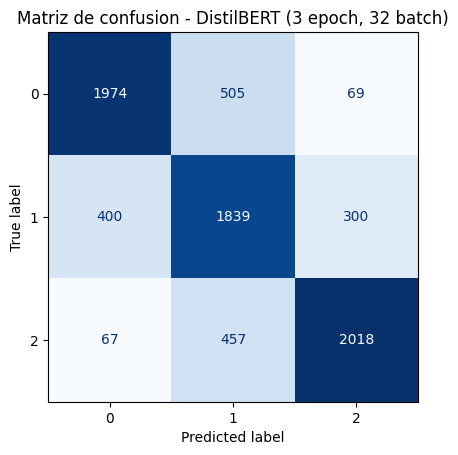

In [ ]:
plot_confusion_matrix(trainer_3_32, test_dataset, titulo='Matriz de confusion - DistilBERT (3 epoch, 32 batch)')

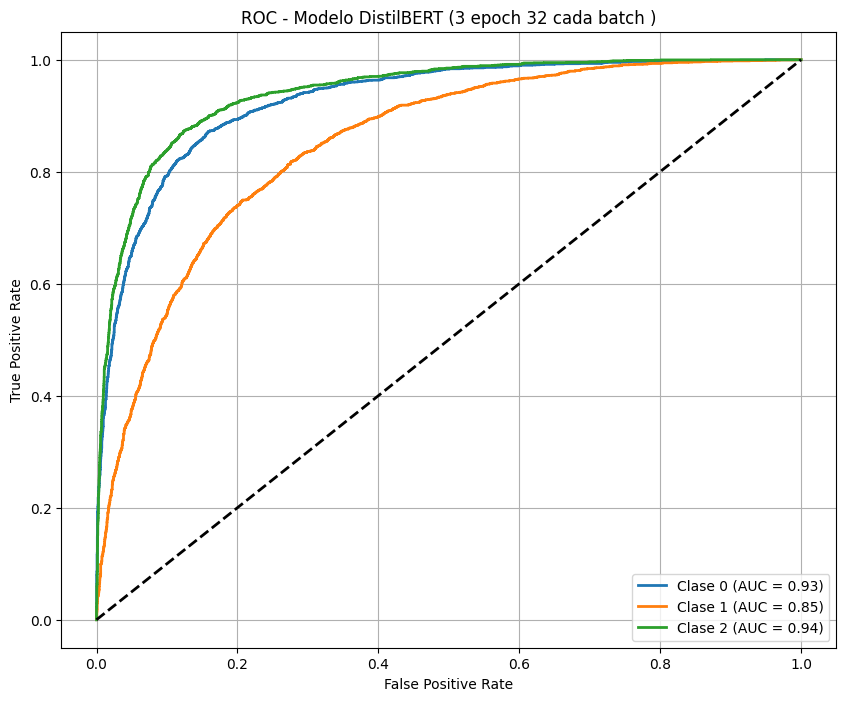

In [ ]:
plot_multiclass_roc(trainer_3_32, test_dataset, titulo='ROC - Modelo DistilBERT (3 epoch 32 cada batch )')

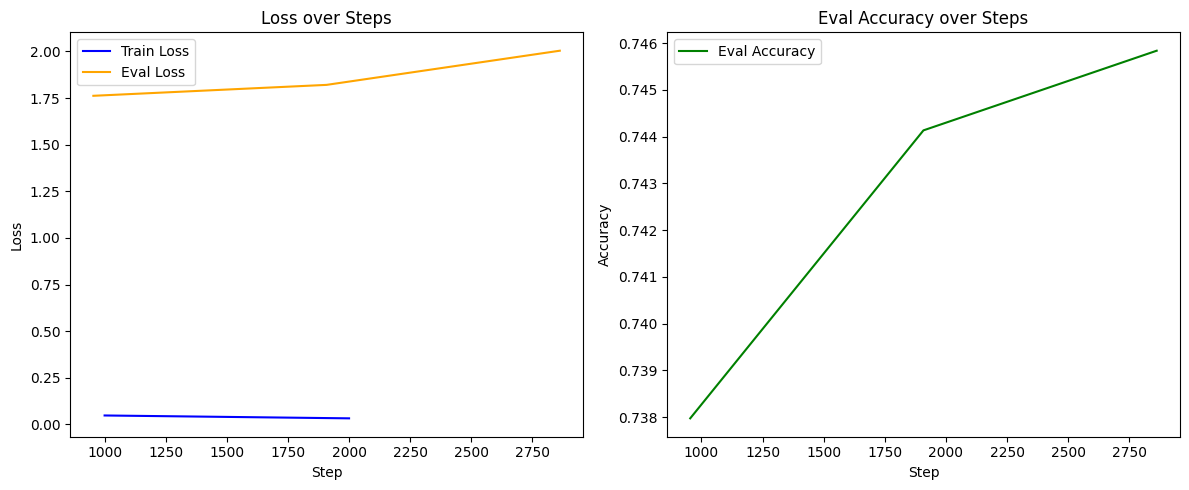

In [ ]:
logs = trainer_3_32.state.log_history
plot_training_logs(logs)

Prueba reduciendo la tasa de aprendizaje

In [ ]:
trainer_3_32 = train_model(
    num_epochs=3,
    batch_size=32,
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    learning_rate=2e-5
)

<ipython-input-44-1ca745de414f>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.245312,0.743479
2,0.011500,2.419341,0.744527
3,0.003500,2.452098,0.746100


In [ ]:
eval_results = trainer_3_32.evaluate()
print(eval_results)

{'eval_accuracy': 0.7461004063442128, 'eval_loss': 2.4520978927612305, 'eval_runtime': 26.5466, 'eval_samples_per_second': 287.381, 'eval_steps_per_second': 9.003, 'epoch': 3.0}


### Nº Épocas: 5

#### Entrenamiento

In [ ]:
# trainer.train()
trainer_5_32 = train_model(
    num_epochs=5,
    batch_size=32,
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-23-1ca745de414f>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.928599,0.737842
2,0.194900,1.230971,0.745707
3,0.125600,1.274396,0.743610
4,0.091500,1.482459,0.744790


In [ ]:
eval_results = trainer_5_32.evaluate()
print(eval_results)

{'eval_accuracy': 0.7457071700091755, 'eval_loss': 1.2309712171554565, 'eval_runtime': 26.332, 'eval_samples_per_second': 289.723, 'eval_steps_per_second': 9.076, 'epoch': 4.0}


#### Representación

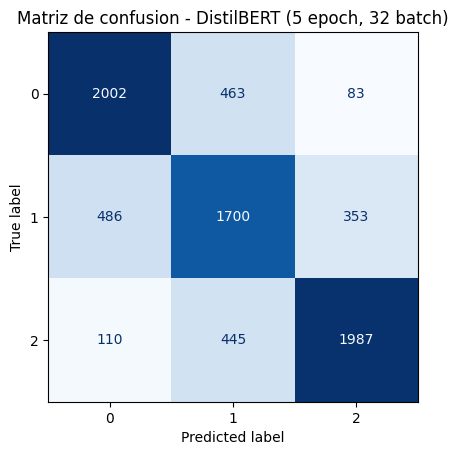

In [ ]:
plot_confusion_matrix(trainer_5_32, test_dataset, titulo='Matriz de confusion - DistilBERT (5 epoch, 32 batch)')


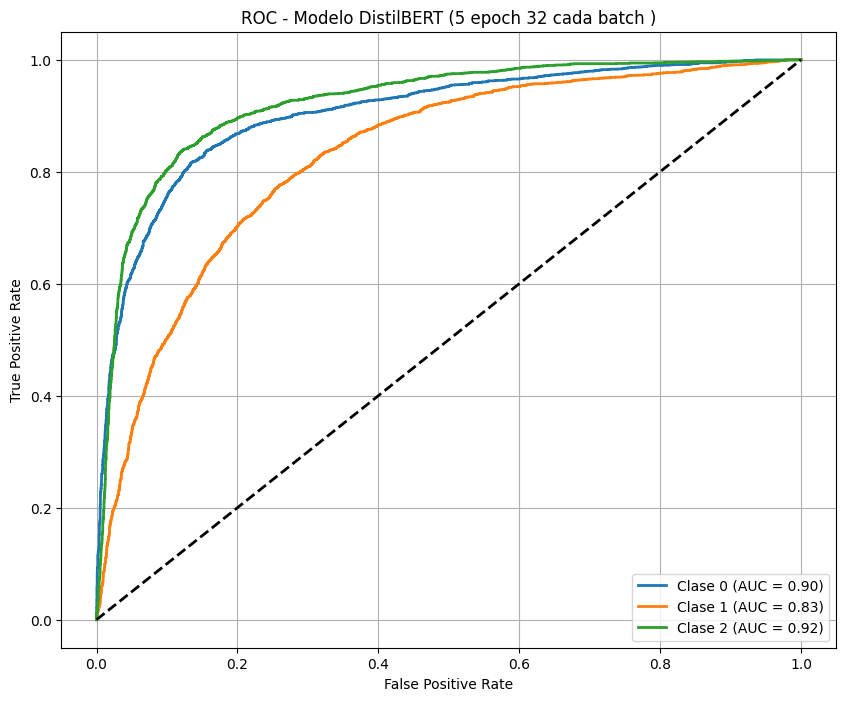

In [ ]:
plot_multiclass_roc(trainer_5_32, test_dataset, titulo='ROC - Modelo DistilBERT (5 epoch 32 cada batch )')


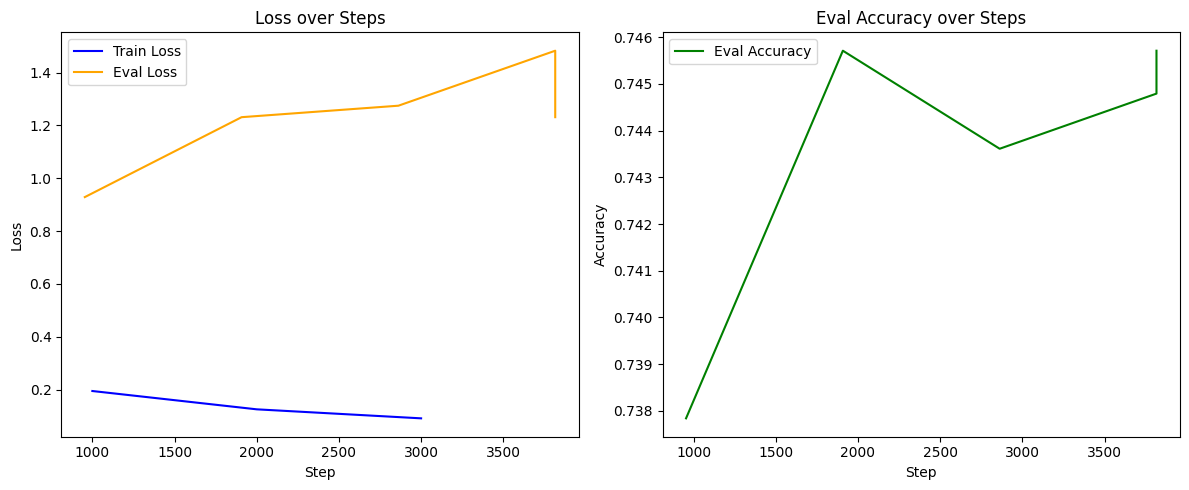

In [ ]:
logs = trainer_5_32.state.log_history
plot_training_logs(logs)

## Batches: 16

#### Nº Epocas: 10

##### Entrenamiento

In [ ]:
trainer_10_16 = train_model(
    num_epochs=10,
    batch_size=16,
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-23-1ca745de414f>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.100200,1.744045,0.723555
2,0.086900,1.965589,0.736663
3,0.068900,2.050874,0.724341
4,0.050900,2.115089,0.726701


##### Resultados

In [ ]:
eval_results = trainer_10_16.evaluate()
print(eval_results)

{'eval_accuracy': 0.7366627343033163, 'eval_loss': 1.9655888080596924, 'eval_runtime': 27.7142, 'eval_samples_per_second': 275.274, 'eval_steps_per_second': 17.211, 'epoch': 4.0}


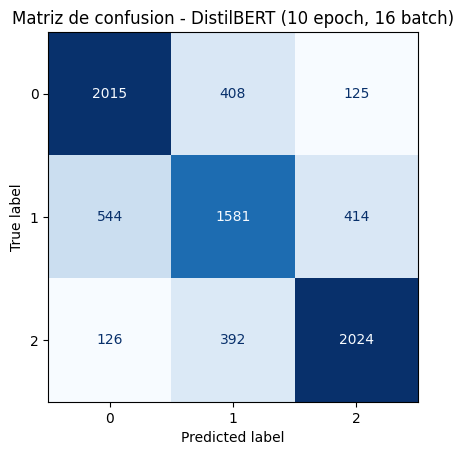

In [ ]:
plot_confusion_matrix(trainer_10_16, test_dataset, titulo='Matriz de confusion - DistilBERT (10 epoch, 16 batch)')

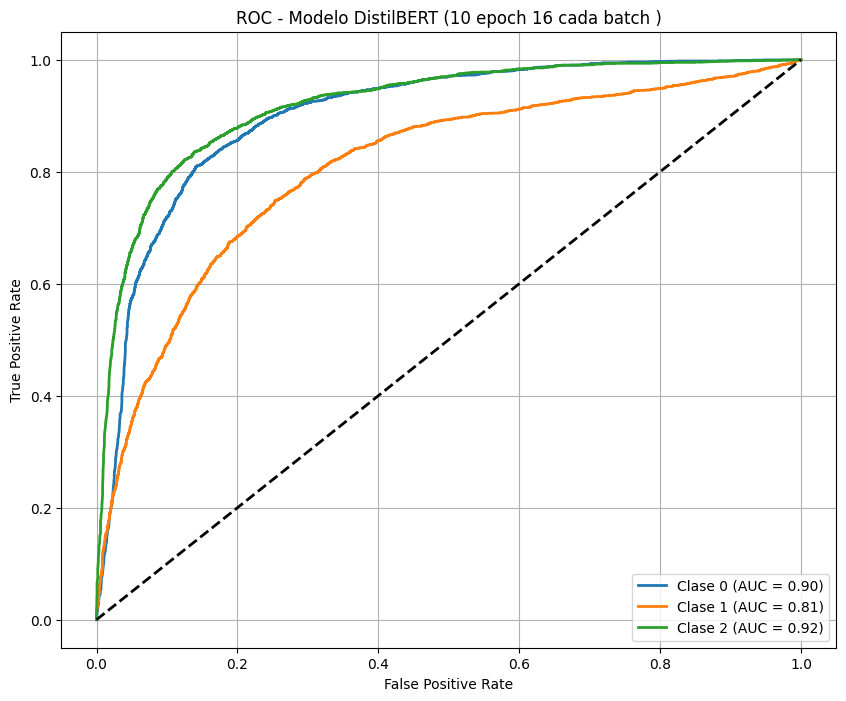

In [ ]:
plot_multiclass_roc(trainer_10_16, test_dataset, titulo='ROC - Modelo DistilBERT (10 epoch 16 cada batch )')

### Curva de aprendizaje

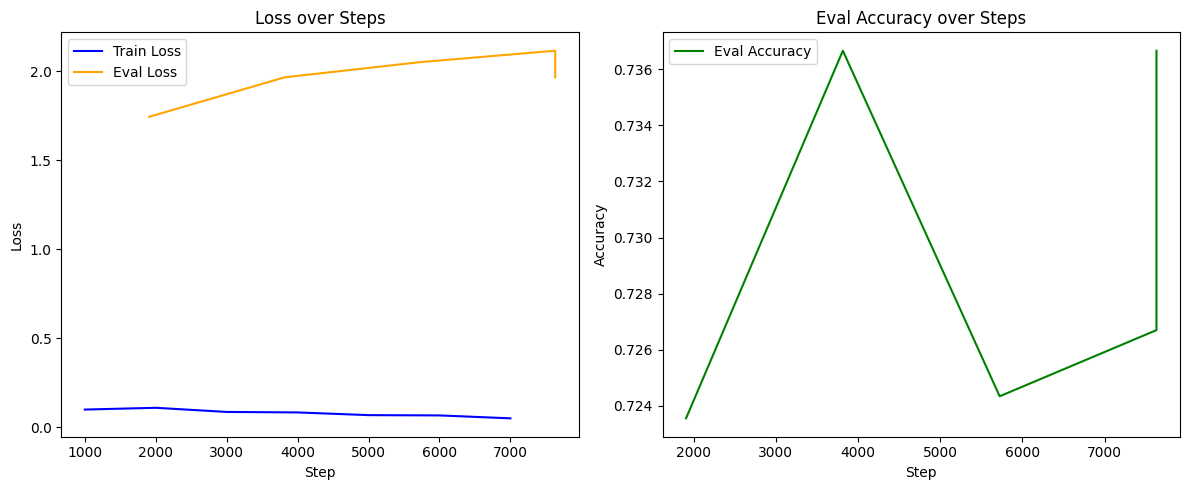

In [ ]:

logs = trainer_10_16.state.log_history
plot_training_logs(logs)




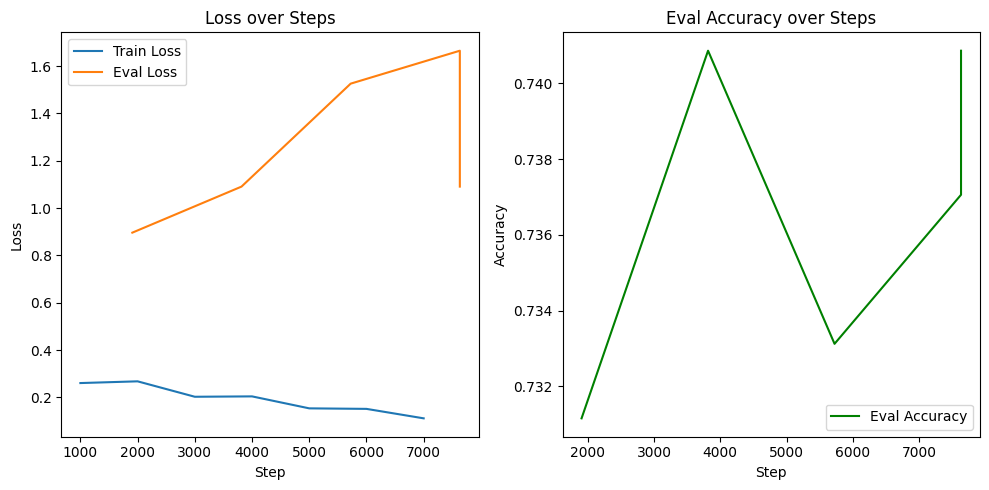

In [ ]:
# Separar por tipo de dato
train_steps = [log['step'] for log in logs if 'loss' in log]
train_loss = [log['loss'] for log in logs if 'loss' in log]

eval_steps = [log['step'] for log in logs if 'eval_loss' in log]
eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]

# Plotear
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)811111
plt.plot(train_steps, train_loss, label='Train Loss')
plt.plot(eval_steps, eval_loss, label='Eval Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Steps')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eval_steps, eval_accuracy, label='Eval Accuracy', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Eval Accuracy over Steps')
plt.legend()

plt.tight_layout()
plt.show()